# Simulate force profiles for a blue-detuned MOT for CaOH

In [ ]:
# Import the packages required for the notebook
using
    Revise,
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue

# A few constants used for the simulation
λ = 626e-9
Γ = 2π * 6.4e6 # in units of MHz
m = @with_unit 57 "u"
k = 2π / λ

# Create a few functions to perform random sampling of position and direction
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

## Load $\tilde{X}(000)$ and $\tilde{A}(000)$ Hamiltonians


In [2]:
HX = load_from_file("CaOH_000_N0to3_Hamiltonian", "..\\..\\..\\QuantumStates\\Hamiltonians\\CaOH\\")
HA = load_from_file("CaOH_A000_J12to52_Hamiltonian", "..\\..\\..\\QuantumStates\\Hamiltonians\\CaOH\\")

# Add Zeeman term to the X state Hamiltonian
const _μB = (μ_B / h) * (1e-6 * 1e-4)
Zeeman_z(state, state′) = Zeeman(state, state′, 0)
HX = add_to_H(HX, :B_z, gS * _μB * Zeeman_z)
HX.parameters.B_z = 1e-6

full_evaluate!(HX); QuantumStates.solve!(HX)
full_evaluate!(HA); QuantumStates.solve!(HA)

HA_J12_pos_parity_states = HA.states[5:8]

# Convert A states from Hund's case (a) to case (b) 
# We'll use the bending mode Hamiltonian for CaOH which has all basis states needed for the conversion
HX_0110 = load_from_file("CaOH_BendingMode_Hamiltonian", "..\\..\\..\\QuantumStates\\Hamiltonians\\CaOH\\")
states_A_J12_caseB = convert_basis(HA_J12_pos_parity_states, HX_0110.basis)
basis_idxs, reduced_A_J12_caseB_basis = states_to_basis(states_A_J12_caseB)
full_basis = [HX.basis; reduced_A_J12_caseB_basis]

for i ∈ eachindex(states_A_J12_caseB)
    states_A_J12_caseB[i].coeffs = states_A_J12_caseB[i].coeffs[basis_idxs]
    states_A_J12_caseB[i].basis = reduced_A_J12_caseB_basis
end

states = [HX.states[5:16]; states_A_J12_caseB]
for state ∈ states
    state.E *= 1e6
end

d = zeros(ComplexF64, 16, 16, 3)
d_ge = zeros(ComplexF64, 12, 4, 3)
basis_tdms = get_tdms_two_bases(HX.basis, reduced_A_J12_caseB_basis, TDM)
tdms_between_states!(d_ge, basis_tdms, HX.states[5:16], states_A_J12_caseB)
d[1:12, 13:16, :] .= d_ge
;

## Zeeman plot for the $X^2\Sigma^+(N=1)$ state in CaOH

In [3]:
function H_func!(H, scan_values)
    H.parameters.B_z = scan_values[1]
    evaluate!(H)
    QuantumStates.solve!(H)
    for i ∈ eachindex(H.states)
        H.states[i].E *= 1e6
    end
    return nothing
end
;

In [4]:
Bs = (0:0.1:20) #.+ 1e-3
scan_params = (
    B_z = Bs,
    );
iterator = Iterators.product
@time scan_values, tracked_idxs = scan_parameters(HX, scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=1)

using Plots
scan_matrix = hcat(values(scan_values)...)'

plot(Bs, scan_matrix[:,5:16], legend=nothing)
hline!([
        J12_energy - δJ12 / 2π
        J32_energy - δJ32 / 2π
        ],
    linestyle=:dash,
    color=:blue
    )
hline!([
        J12_energy - δJ12_red / 2π
        J32_energy - δJ32_red / 2π
        ],
    linestyle=:dash,
    color=:red
    )
plot!(
    # xlim=(-100.,100.),
    size=(600,700)
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


  2.831851 seconds (7.49 M allocations: 443.571 MiB, 5.72% gc time, 91.79% compilation time)


LoadError: UndefVarError: δJ12 not defined

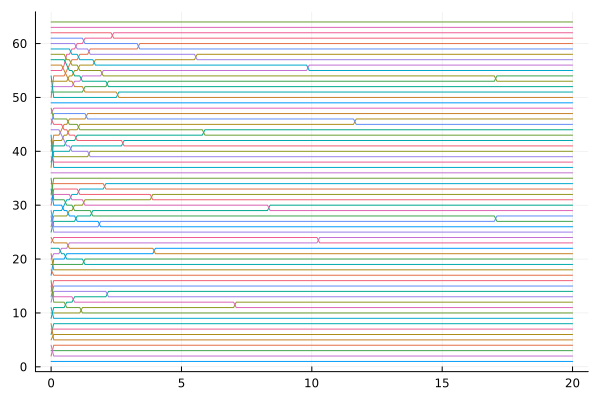

In [5]:
plot(Bs, hcat(values(tracked_idxs)...)', legend=nothing)

In [6]:
function g_factor(H)
    ΔB = 1e-6
    
    evaluate!(H)
    QuantumStates.solve!(H)
    bare_energies = energy.(H.states)
    
    H.parameters.B_z += ΔB
    evaluate!(H)
    QuantumStates.solve!(H)
    B_energies = energy.(H.states)

    # `H` needs to be "reset" for the next calculation
    H.parameters.B_z -= ΔB
    
    return (B_energies .- bare_energies) ./ ΔB
end

g_factor (generic function with 1 method)

In [7]:
Bs = 0:0.01:40
scan_values = (
    B_z = Bs,
    );
iterator = Iterators.product
@time x = scan_parameters(deepcopy(HX_N1), scan_values, iterator, H_func!, g_factor, n_threads=1)
;

LoadError: UndefVarError: HX_N1 not defined

In [8]:
plot(Bs, hcat(values(x)...)', legend=nothing, size=(1000,600))
vline!([3])

LoadError: UndefVarError: x not defined

## Set parameters

In [9]:
# Laser parameters
J12_energy = energy(states[1])
J32_energy = energy(states[5])
A_energy = energy(states[13])

Isat = π * h * c * Γ / (3λ^3) * 1e-1 # in mW/cm^2
;

In [98]:
# # CaOH MOT settings
# I_load = 32 / 2 # mW/cm^2, or 33 mW per beam of 1/e² diameter = 1 cm (divide by 2 to account for power split between SR frequencies)
# I_ramped = I_load / 11 # after ramping down the MOT

# s_J12 = I_load / Isat
# s_J32 = I_load / Isat
# s_J12_blue = s_J12
# s_J32_blue = s_J32

# Note: 1 V power = 13 mW
I = 2 * 7.0  / (π * (0.5)^2)
I_scaled = I
s = I_scaled / Isat

# Red-detuned
# δJ12 = -Γ # -1.0Γ
# δJ32 = -Γ # -1.0Γ
# δJ12_blue = +2.0Γ
# δJ32_blue = +2.0Γ
# pol_J12 = σ⁻ # σ⁺
# pol_J32 = σ⁺ # σ⁻
# pol_J12_blue = σ⁺ # σ⁻
# pol_J32_blue = σ⁻ # σ⁺

# Two-frequency settings
# s_J12 = 4.0
# s_J32 = 2.0
# s_J12_red = 0.0
# s_J32_red = 0.0
# δJ12 = +2.0Γ
# δJ32 = +2.0Γ
# δJ12_red = -2.0Γ
# δJ32_red = -2.0Γ
# pol_J12 = σ⁺
# pol_J32 = σ⁻
# pol_J12_red = σ⁻
# pol_J32_red = σ⁺

# Three-frequency settings
# δJ12 = +2Γ
# δJ32 = +2Γ
# δJ12_red = -2.5Γ
# δJ32_red = -2.5Γ
# pol_J12 = σ⁻
# pol_J32 = σ⁺
# pol_J12_red = σ⁺
# pol_J32_red = σ⁻
# s_J12 = 15
# s_J32 = 4
# s_J12_red = 0
# s_J32_red = 2
# δJ12 = +2Γ
# δJ32 = +2Γ
# δJ12_red = -2.5Γ
# δJ32_red = -2.5Γ
# pol_J12 = σ⁺
# pol_J32 = σ⁻
# pol_J12_red = σ⁻
# pol_J32_red = σ⁺
# s_J12 = s * 0.65
# s_J32 = s * 0.35
# s_J12_red = s * 1.00
# s_J32_red = s * 0.00

# Langin parameters
# δJ12_red = -1.5Γ
# δJ12 = +1Γ
# δJ32 = +3Γ
# pol_J12_red = σ⁺
# pol_J12 = σ⁻
# pol_J32 = σ⁻
# s_J12_red = 6
# s_J12 = 2
# s_J32 = 16

# s_J32_red = 0.0 # not used
# pol_J32_red = σ⁻
# δJ32_red = -2.0Γ

# δJ12 = +4Γ
# δJ32 = +3Γ
# δJ12_red = 0Γ
# δJ32_red = -3Γ
# pol_J12 = σ⁺
# pol_J32 = σ⁺
# pol_J12_red = σ⁻
# pol_J32_red = σ⁻
# s_J12 = 2.5
# s_J32 = 0.5
# s_J12_red = 0
# s_J32_red = 0.5

# Single frequency
s_J12 = 19.0
s_J32 = 0.0
s_J12_red = 0.0
s_J32_red = 0.0
δJ12 = +10.0Γ
δJ32 = +3.0Γ
δJ12_red = -2.0Γ
δJ32_red = -4.0Γ
pol_J12 = σ⁺
pol_J32 = σ⁻
pol_J12_red = σ⁻
pol_J32_red = σ⁺

ω_J12 = 2π * (A_energy - J12_energy) + δJ12
ω_J32 = 2π * (A_energy - J32_energy) + δJ32

ω_J12_red = 2π * (A_energy - J12_energy) + δJ12_red
ω_J32_red = 2π * (A_energy - J32_energy) + δJ32_red

ϵ(ϵ1) = t -> ϵ1

ϵ1 = ϵ( rotate_pol(pol_J12, -x̂)); laser1 = Field(+x̂, ϵ1, ω_J12, s_J12)
ϵ2 = ϵ( rotate_pol(pol_J12, +x̂)); laser2 = Field(-x̂, ϵ2, ω_J12, s_J12)
ϵ3 = ϵ( rotate_pol(pol_J12, -ŷ)); laser3 = Field(+ŷ, ϵ3, ω_J12, s_J12)
ϵ4 = ϵ( rotate_pol(pol_J12, +ŷ)); laser4 = Field(-ŷ, ϵ4, ω_J12, s_J12)
ϵ5 = ϵ( rotate_pol(pol_J12, -ẑ)); laser5 = Field(+ẑ, ϵ5, ω_J12, s_J12)
ϵ6 = ϵ( rotate_pol(pol_J12, +ẑ)); laser6 = Field(-ẑ, ϵ6, ω_J12, s_J12)

lasers_J12_1D = [laser5, laser6]
lasers_J12 = [laser1, laser2, laser3, laser4, laser5, laser6]

ϵ7  = ϵ( rotate_pol(pol_J32, -x̂)); laser7  = Field(+x̂, ϵ7,  ω_J32, s_J32)
ϵ8  = ϵ( rotate_pol(pol_J32, +x̂)); laser8  = Field(-x̂, ϵ8,  ω_J32, s_J32)
ϵ9  = ϵ( rotate_pol(pol_J32, -ŷ)); laser9  = Field(+ŷ, ϵ9,  ω_J32, s_J32)
ϵ10 = ϵ( rotate_pol(pol_J32, +ŷ)); laser10 = Field(-ŷ, ϵ10, ω_J32, s_J32)
ϵ11 = ϵ( rotate_pol(pol_J32, -ẑ)); laser11 = Field(+ẑ, ϵ11, ω_J32, s_J32)
ϵ12 = ϵ( rotate_pol(pol_J32, +ẑ)); laser12 = Field(-ẑ, ϵ12, ω_J32, s_J32)

lasers_J32_1D = [laser11, laser12]
lasers_J32 = [laser7, laser8, laser9, laser10, laser11, laser12]

ϵ13 = ϵ( rotate_pol(pol_J12_red, -x̂)); laser13 = Field(+x̂, ϵ13, ω_J12_red, s_J12_red)
ϵ14 = ϵ( rotate_pol(pol_J12_red, +x̂)); laser14 = Field(-x̂, ϵ14, ω_J12_red, s_J12_red)
ϵ15 = ϵ( rotate_pol(pol_J12_red, -ŷ)); laser15 = Field(+ŷ, ϵ15, ω_J12_red, s_J12_red)
ϵ16 = ϵ( rotate_pol(pol_J12_red, +ŷ)); laser16 = Field(-ŷ, ϵ16, ω_J12_red, s_J12_red)
ϵ17 = ϵ( rotate_pol(pol_J12_red, -ẑ)); laser17 = Field(+ẑ, ϵ17, ω_J12_red, s_J12_red)
ϵ18 = ϵ( rotate_pol(pol_J12_red, +ẑ)); laser18 = Field(-ẑ, ϵ18, ω_J12_red, s_J12_red)

lasers_J12_red_1D = [laser17, laser18]
lasers_J12_red = [laser13, laser14, laser15, laser16, laser17, laser18]

ϵ19 = ϵ( rotate_pol(pol_J32_red, -x̂)); laser19 = Field(+x̂, ϵ19, ω_J32_red, s_J32_red)
ϵ20 = ϵ( rotate_pol(pol_J32_red, +x̂)); laser20 = Field(-x̂, ϵ20, ω_J32_red, s_J32_red)
ϵ21 = ϵ( rotate_pol(pol_J32_red, -ŷ)); laser21 = Field(+ŷ, ϵ21, ω_J32_red, s_J32_red)
ϵ22 = ϵ( rotate_pol(pol_J32_red, +ŷ)); laser22 = Field(-ŷ, ϵ22, ω_J32_red, s_J32_red)
ϵ23 = ϵ( rotate_pol(pol_J32_red, -ẑ)); laser23 = Field(+ẑ, ϵ23, ω_J32_red, s_J32_red)
ϵ24 = ϵ( rotate_pol(pol_J32_red, +ẑ)); laser24 = Field(-ẑ, ϵ24, ω_J32_red, s_J32_red)

lasers_J32_red_1D = [laser23, laser24]
lasers_J32_red = [laser19, laser20, laser21, laser22, laser23, laser24]

# lasers = [lasers_J12; lasers_J32]
# lasers = [lasers_J12; lasers_J32; lasers_J12_red]
# lasers = [lasers_J12; lasers_J32; lasers_J32_red]
lasers = [lasers_J12; lasers_J32; lasers_J12_red; lasers_J32_red]
# lasers = [lasers_J12_1D; lasers_J32_1D; lasers_J12_red_1D; lasers_J32_red_1D]
;

In [99]:
# Set initial conditions
particle = Particle()

ρ0 = zeros(ComplexF64, length(states), length(states)) # Use a static array for this??? Might be better...
ρ0[1,1] = 1.0

extra_p = (basis_tdms=basis_tdms, HX=HX, d_ge=d_ge)
freq_res = 1e-2
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

p.r0 = (0.0, 0.0, 0.0) .* 2π
p.v = (0., 0., +0.5) #./ (Γ / k)
p.v = round_vel(p.v, p.freq_res)
;

In [100]:
# using BenchmarkTools
# dρ = deepcopy(p.ρ0_vec)
# @time ρ!(dρ, p.ρ0_vec, p, 0.0)
# @btime ρ!($dρ, $p.ρ0_vec, $p, 0.0)

In [101]:
t_end = 10p.period+1
tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
;

In [102]:
prob.p.force_last_period = (0, 0, 0)
cb = PeriodicCallback(reset_force!, p.period)
@time sol = DifferentialEquations.solve(prob, DP5(), callback=cb, abstol=1e-6)
;

 13.494025 seconds (15.96 M allocations: 2.920 GiB, 33.15% gc time, 57.00% compilation time)


In [103]:
sol.t[end], t_end

(5654.8667764616275, 6284.185307179587)

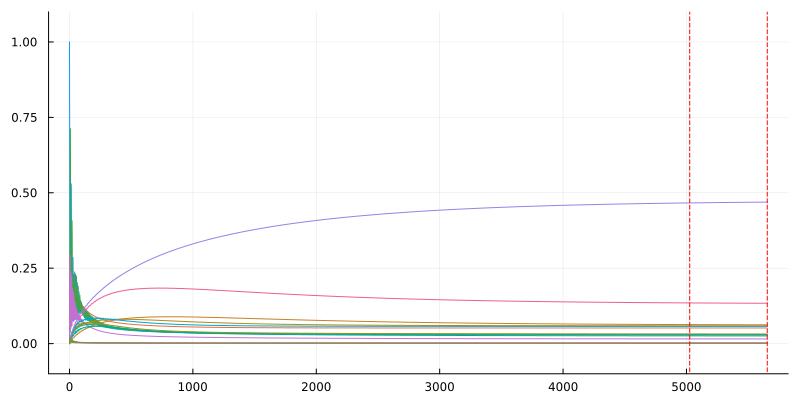

In [104]:
using Plots
plot_us = sol.u[1:10:end]
plot_ts = sol.t[1:10:end]

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)
# vline!([280, 380], color="red", linestyle=:dash)

In [105]:
prob.p.force_last_period * (1e-3 * ħ * k * Γ / m)

3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 -4.325692583696592e-5
 -2.0638053830289518e-6
 -0.24761910812775245

In [106]:
prob.p.force_last_period * (1e-3 * ħ * k * Γ / m)

3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 -4.325692583696592e-5
 -2.0638053830289518e-6
 -0.24761910812775245

In [107]:
prob.p.populations

16-element Vector{ComplexF64}:
  0.029078937861107542 + 0.0im
  0.051876346877386584 + 0.0im
    0.0295529710910946 + 0.0im
  0.015542193044842502 + 0.0im
  0.058913485818363795 + 0.0im
  0.030118086946480018 + 0.0im
   0.13428355930731709 + 0.0im
    0.0627059508206891 + 0.0im
  0.025619667799671307 + 0.0im
   0.03206019862474783 + 0.0im
   0.05710515282466124 + 0.0im
    0.4678870742802269 + 0.0im
 0.0011504530230634041 + 0.0im
 0.0010995325764934236 + 0.0im
 0.0007181127752331621 + 0.0im
  0.002288276329025788 + 0.0im

## Force versus velocity

In [108]:
function prob_func!(prob, scan_values, i)
    # Update velocity and position
    prob.p.v .= sample_direction(scan_values.v[i]) # (0, 0, scan_values.v[i])
    prob.p.v .= round_vel(prob.p.v, prob.p.freq_res)    
    prob.p.r0 .= rand(uniform_dist, 3)
    return prob
end
function param_func(prob, scan_values, i)
    return scan_values.v[i]
end
function output_func(p, sol)
    f = p.force_last_period
    f_proj = (f ⋅ p.v) / norm(p.v)
    return isnan(f_proj) ? 0.0 : f_proj
    # return f[3]
end
;

In [109]:
freq_res = 1e-2
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 20p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, abstol=1e-6, save_on=false)

n_samples = 50

prob.p.B .= (0.0, 0.0, 0.0)
# vs = repeat([collect(0:0.2:2.0); collect(2.2:0.3:4.5); collect(5:1:10)], n_samples) ./ (Γ / k)
# vs = repeat([collect(0:0.02:0.1); collect(0.2:0.1:1.0); collect(1.25:0.25:3)], n_samples) ./ (Γ / k)
# vs = repeat([collect(0:0.02:0.1); collect(0.2:0.2:2.0); collect(3.0:2.0:51)], n_samples) ./ (Γ / k)
# vs = repeat(collect(0.0:2.0:50), n_samples) ./ (Γ / k)
vs = repeat([collect(0:0.02:0.1); collect(0.2:0.2:5.0)], n_samples) ./ (Γ / k)

scan_values = (v = vs,)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:01:40


103.406267 seconds (16.54 M allocations: 2.030 GiB, 0.52% gc time, 9.19% compilation time)


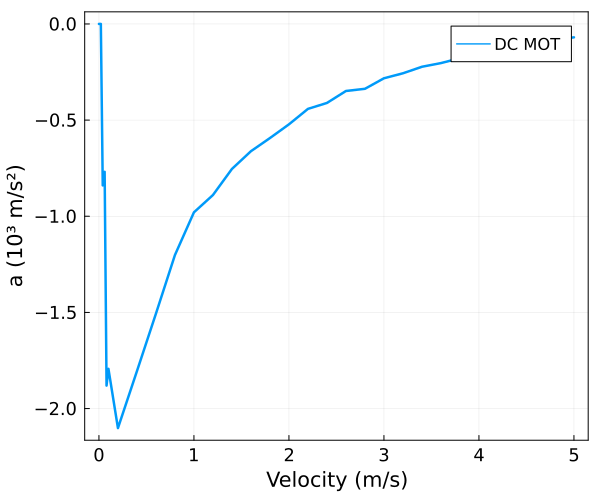

In [110]:
@time scan_params, forces, populations_velocity = force_scan(prob, scan_values, prob_func!, param_func, output_func);
vs, averaged_forces_velocity, stddev_velocity = average_values(scan_params, forces)
plot(vs .* (Γ / k), (1e-3 * ħ * k * Γ / m) .* averaged_forces_velocity,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # ylim=(-8,6),
    label="DC MOT",
    size=(600,500)
    )

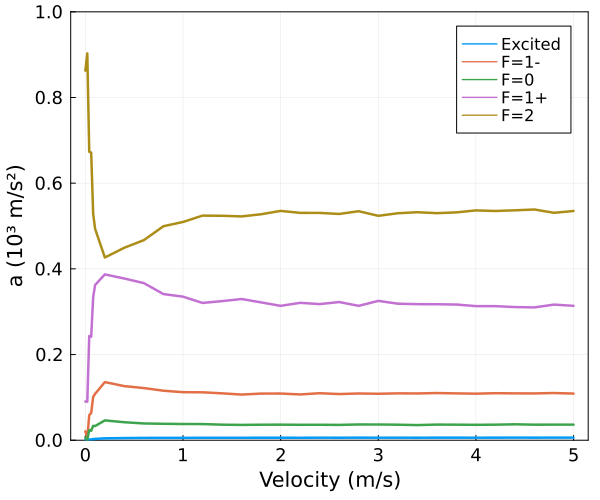

In [111]:
vs, averaged_populations_velocity = average_values(scan_params, populations_velocity)
plot(vs .* (Γ / k), sum(averaged_populations_velocity[:,13:16], dims=2), 
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    ylim=(0,1),
    size=(600,500),
    label="Excited"
    )
plot!(vs .* (Γ / k), sum(averaged_populations_velocity[:,1:3], dims=2), linewidth=2.5, label="F=1-")
plot!(vs .* (Γ / k), sum(averaged_populations_velocity[:,4], dims=2), linewidth=2.5, label="F=0")
plot!(vs .* (Γ / k), sum(averaged_populations_velocity[:,5:7], dims=2), linewidth=2.5, label="F=1+")
plot!(vs .* (Γ / k), sum(averaged_populations_velocity[:,8:12], dims=2), linewidth=2.5, label="F=2")

In [112]:
Γ .* sum(averaged_populations_velocity[:,13:16], dims=2)

31×1 Matrix{Float64}:
   3221.9552240174876
   3059.0025790663135
  62651.00449663797
  63158.72207850267
 113516.2269966477
 122540.8613175846
 178448.40536759648
 201328.700990981
 218115.93817654782
 220669.7278542987
 221386.62122015437
 231082.89185912165
 228719.23786894945
      ⋮
 239451.80888935327
 235329.541414691
 237334.26200282623
 233659.15266260318
 240106.38221244115
 239199.6819972649
 236417.8971301848
 239633.97413820346
 242561.5014354661
 239831.1748891344
 242874.45016976475
 242074.8280627253

## Force versus magnetic field

In [140]:
function prob_func!(prob, scan_values, i)
    p = prob.p

    # Solve Hamiltonian for new `Bz` value (this is expensive, so only do it if the value has changed)
    Bz = scan_values.Bz[i]
    
    if p.extra_p.HX.parameters.B_z != Bz
        
        # Solve X state Hamiltonian for new B_z value
        p.extra_p.HX.parameters.B_z = Bz 
        evaluate!(p.extra_p.HX)
        QuantumStates.solve!(p.extra_p.HX)
        for i ∈ eachindex(p.extra_p.HX.states)
            p.extra_p.HX.states[i].E *= 1e6
        end
        
        # Solve A state Hamiltonian for new B_z value
        # p.extra_p.HA_J12.parameters.B_z = 0. #Bz
        # evaluate!(p.extra_p.HA_J12)
        # QuantumStates.solve!(p.extra_p.HA_J12)
        # for i ∈ eachindex(p.extra_p.HA_J12.states)
        #     p.extra_p.HA_J12.states[i].E *= 1e6
        # end
        # J12_positive_parity = p.extra_p.HA_J12.states[5:8]
        # J12_positive_parity_caseB = convert_basis(J12_positive_parity, p.extra_p.reduced_A_J12_caseB_basis)
        
        # Update TDMs
        tdms_between_states!(p.extra_p.d_ge, p.extra_p.basis_tdms, p.extra_p.HX.states[5:16], p.extra_p.states_A_J12_caseB)
        p.d[1:12, 13:16, :] .= p.extra_p.d_ge
        
        states′ = [p.extra_p.HX.states[5:16]; p.extra_p.states_A_J12_caseB]

        extra_p = (
            basis_tdms=p.extra_p.basis_tdms, 
            HX=p.extra_p.HX, 
            d_ge=p.extra_p.d_ge, 
            reduced_A_J12_caseB_basis=p.extra_p.reduced_A_J12_caseB_basis, 
            states_A_J12_caseB=p.extra_p.states_A_J12_caseB)
        new_p = obe(
            p.ρ0, p.particle, states′, p.fields, p.d, p.d, true, true, p.λ, p.Γ, p.freq_res, extra_p
        )
    else
        new_p = p
    end
    
    # Update velocity, position, and "reset" the frequencies of the lasers
    # (Technically, we're only overwriting the laser frequencies in `new_p` here because `obe` changes them when there's no need to 
    # -- will need to shore up how this is handled.)
    new_p.v .= sample_direction(0.0) # ./ (p.Γ / p.k)
    new_p.r0 .= rand(uniform_dist, 3)
    new_p.fields.ω .= p.fields.ω
    
    # Ensure that frequencies and velocities are rounded
    round_params(new_p)
    
    return remake(prob, p=new_p)
end
function param_func(prob, scan_values, i)
    return scan_values.Bz[i]
end
function output_func(p, sol)
    f = p.force_last_period
    return f[3] #(f ⋅ p.v) / norm(p.v)
end
;

In [177]:
freq_res = 1e-1
extra_p = (basis_tdms=basis_tdms, HX=HX, d_ge=d_ge, reduced_A_J12_caseB_basis=reduced_A_J12_caseB_basis, states_A_J12_caseB=states_A_J12_caseB)
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 50p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, abstol=1e-5, save_on=false)

Bzs = (0:4.:20)
# rs = vec([[rx, ry, rz] for rx in (0:1/16:0.95), ry in (0:1/16:0.95), rz in (0:1/16:0.95)])
# vs = [0.0]
# iterator = Iterators.product(Bzs, rs, vs)

n_samples = 5000

scan_values = (Bz = repeat(Bzs, n_samples),)
;

In [178]:
@time scan_params, forces_magnetic, populations_magnetic = force_scan(prob, scan_values, prob_func!, param_func, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:07:57


477.577586 seconds (19.04 M allocations: 15.678 GiB, 0.69% gc time)


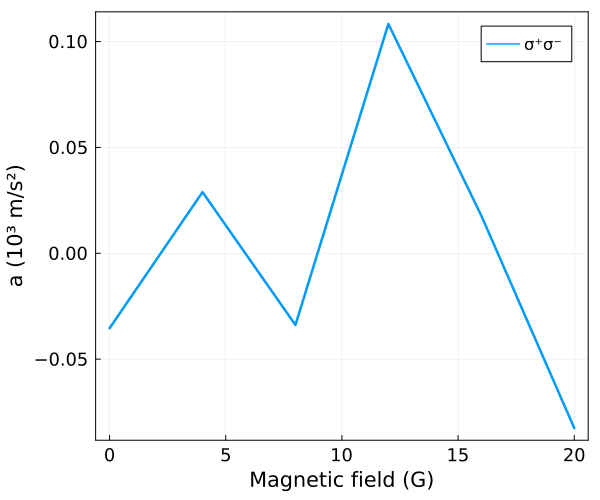

In [179]:
Bzs, averaged_forces_magnetic, stddev_forces_magnetic = average_values(scan_params, forces_magnetic)
plot(Bzs, (1e-3 * ħ * k * Γ / m) .* averaged_forces_magnetic, 
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # xlim=(0,10),
    # ylim=(-3,0),
    label="σ⁺σ⁻",
    size=(600,500)
    )

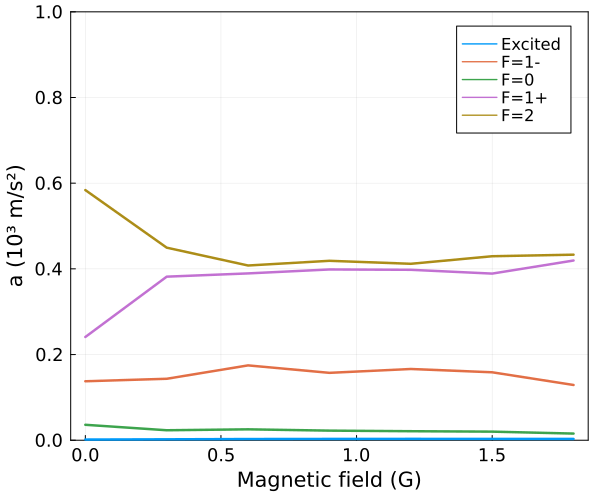

In [172]:
Bzs, averaged_populations_magnetic = average_values(scan_params, populations_magnetic)
plot(Bzs, sum(averaged_populations_magnetic[:,13:16], dims=2), 
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # xlim=(0,10),
    ylim=(0,1),
    size=(600,500),
    label="Excited"
    )
plot!(Bzs, sum(averaged_populations_magnetic[:,1:3], dims=2), linewidth=2.5, label="F=1-")
plot!(Bzs, sum(averaged_populations_magnetic[:,4], dims=2), linewidth=2.5, label="F=0")
plot!(Bzs, sum(averaged_populations_magnetic[:,5:7], dims=2), linewidth=2.5, label="F=1+")
plot!(Bzs, sum(averaged_populations_magnetic[:,8:12], dims=2), linewidth=2.5, label="F=2")

In [167]:
Γ .* sum(averaged_populations_magnetic[:,13:16], dims=2)

7×1 Matrix{Float64}:
  61368.222527894686
  84683.66037463279
 110699.54700991236
 119770.632885919
 125625.86775948947
 122334.79118570164
 120347.98342827609

In [168]:
minimum((1e-3 * ħ * k * Γ / m) .* averaged_forces_magnetic) / maximum(Γ .* sum(averaged_populations_magnetic[:,13:16], dims=2))

-1.472360837235762e-6

# Prepare interpolation for Monte Carlo simulations

In [731]:
using RectiGrids

In [732]:
function prob_func!(prob, scan_values, i)
    p = prob.p

    # Solve Hamiltonian for new `Bz` value (this is expensive, so only do it if the value has changed)
    Bz = scan_values[i].B
    vx = scan_values[i].vx
    vy = scan_values[i].vy
    vz = scan_values[i].vz
    
    if p.extra_p.HX.parameters.B_z != Bz
        
        # Solve X state Hamiltonian for new B_z value
        p.extra_p.HX.parameters.B_z = Bz 
        evaluate!(p.extra_p.HX)
        QuantumStates.solve!(p.extra_p.HX)
        for i ∈ eachindex(p.extra_p.HX.states)
            p.extra_p.HX.states[i].E *= 1e6
        end
        
        # Update TDMs
        tdms_between_states!(p.extra_p.d_ge, p.extra_p.basis_tdms, p.extra_p.HX.states[5:16], p.extra_p.states_A_J12_caseB)
        p.d[1:12, 13:16, :] .= p.extra_p.d_ge
        
        states′ = [p.extra_p.HX.states[5:16]; p.extra_p.states_A_J12_caseB]

        extra_p = (
            basis_tdms=p.extra_p.basis_tdms, 
            HX=p.extra_p.HX, 
            d_ge=p.extra_p.d_ge, 
            reduced_A_J12_caseB_basis=p.extra_p.reduced_A_J12_caseB_basis, 
            states_A_J12_caseB=p.extra_p.states_A_J12_caseB)
        new_p = obe(
            p.ρ0, p.particle, states′, p.fields, p.d, p.d, true, true, p.λ, p.Γ, p.freq_res, extra_p
        )
    else
        new_p = p
    end
    
    # Update velocity, position, and "reset" the frequencies of the lasers
    # (Technically, we're only overwriting the laser frequencies in `new_p` here because `obe` changes them when there's no need to 
    # -- will need to shore up how this is handled.)
    new_p.v .= (vx, vy, vz)
    new_p.r0 .= rand(uniform_dist, 3)
    new_p.fields.ω .= p.fields.ω
    
    # Ensure that frequencies and velocities are rounded
    round_params(new_p)
    
    return remake(prob, p=new_p)
end
function output_func(p, sol)
    f = p.force_last_period
    return f
end
;

In [231]:
freq_res = 1e-1
extra_p = (basis_tdms=basis_tdms, HX=HX, d_ge=d_ge, reduced_A_J12_caseB_basis=reduced_A_J12_caseB_basis, states_A_J12_caseB=states_A_J12_caseB)
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 20p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, abstol=1e-5, save_on=false)
;

In [232]:
grid_range_B = 0:4.:40
grid_range_vx = 0.:0
grid_range_vy = 0.:0
grid_range_vz = -10:0.1:10

n_samples = 100

scan_values = (B = grid_range_B, vx = grid_range_vx, vy = grid_range_vy, vz = grid_range_vz)
scan_values_grid = RectiGrids.grid(scan_values)
scan_values_grid_n = RectiGrids.grid((i = 1:n_samples, scan_values...))
;

In [233]:
forces, populations = force_scan_v2(prob, scan_values_grid_n, prob_func!, output_func)
;

In [237]:
using DataFrames
df = select!(DataFrame(scan_values_grid_n), keys(scan_values)...)
df.force_x = [x[1] for x ∈ forces]
df.force_y = [x[2] for x ∈ forces]
df.force_z = [x[3] for x ∈ forces]
;

In [238]:
gdf = groupby(df, :B)
force_means = combine(gdf,
    :force_x => mean, 
    :force_y => mean,
    :force_z => mean
    )

,B,force_x_mean,force_y_mean,force_z_mean
,Float64,Float64,Float64,Float64
1,0.0,-0.000126706,-4.59503e-5,3.30409e-5
2,4.0,-8.50115e-5,4.00926e-5,3.35764e-5
3,8.0,-0.000318566,5.20059e-5,-4.44252e-5
4,12.0,-1.0727e-5,8.305e-5,-4.5542e-5
5,16.0,-9.72453e-5,-0.000178506,-9.37042e-6
6,20.0,4.64122e-5,-6.32297e-5,-5.59176e-5
7,24.0,4.30972e-5,-2.05408e-5,-9.18276e-5
8,28.0,0.000121461,8.94223e-5,-4.38254e-5
9,32.0,0.000203235,-0.000142281,-4.553e-5


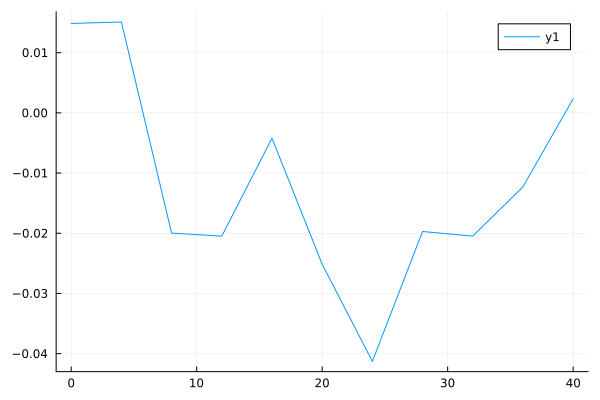

In [244]:
plot(force_means.B, (1e-3 * ħ * k * Γ / m) .* force_means.force_z_mean)